In [1]:
import scipy.io as sio
import numpy as np

In [2]:
datasets = sio.loadmat('./train_data.mat')

In [3]:
# Do the waveforms
train_data = np.concatenate(([dataset[0][1] for dataset in datasets['all_datasets']]), axis=0)

In [4]:
size = datasets['all_datasets'][0][0][1].shape[0]
# Figure out how many labels there'll be
train_labels = np.zeros((train_data.shape[0],1))
for i in range(datasets['all_datasets'].shape[0]):
    train_labels[(i)*size:(i+1)*size] = np.ones((datasets['all_datasets'][0][0][0].shape[0]))*datasets['all_datasets'][i][0][2]

# One hot encoding
labels = np.reshape(train_labels, [-1]) # Reshape into (N,) from (N,1), otherwise assignments get messed up
labels_encoded = np.zeros((labels.shape[0], int(train_labels.max())))
labels_encoded[np.arange(labels.shape[0]), labels.astype(int)-1] = 1

In [5]:
import tensorflow as tf

In [6]:
tf.__version__

'1.8.0'

In [7]:
my_input = tf.placeholder(tf.float32, shape=(None, train_data.shape[1], train_data.shape[2]))

# Create conv net
x_image = tf.reshape(my_input, [-1, 128, 2, 1])

num_filt0 = 32
num_filt1 = 16

# First conv layer
W_conv1 = tf.Variable(tf.truncated_normal([16, 2, 1, num_filt0], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filt0]))

h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='VALID') + b_conv1)

# Second conv layer
W_conv2 = tf.Variable(tf.truncated_normal([8, 1, num_filt0, num_filt1], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filt1]))

h_conv2 = tf.nn.relu(tf.nn.conv2d(h_conv1, W_conv2, strides=[1, 1, 1, 1], padding='VALID') + b_conv2)

h_flat = tf.reshape(h_conv2, [-1, h_conv2.get_shape().as_list()[1] * num_filt1])

nn_out = tf.layers.dense(inputs=h_flat, units=6, activation=tf.nn.relu)

In [8]:
onehot_labels = tf.placeholder(tf.float32, shape=(None, 6))

loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=nn_out)

optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001)

train_op = optimizer.minimize(loss)

correct_prediction = tf.equal(tf.argmax(nn_out, 1), tf.argmax(onehot_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
train_labels = labels_encoded

batch_size = 32
num_epochs = 100

losses = []
#tf.reset_default_graph()
sess = tf.Session()

sess.run(tf.global_variables_initializer())
for epoch in range(num_epochs):

    # Randomize
    indexes = np.arange(train_labels.shape[0])
    np.random.shuffle(indexes)

    train_data = train_data[indexes]
    train_labels = train_labels[indexes]

    for i in range(int(train_data.shape[0]/batch_size)):
        batch = train_data[range(i*batch_size,(i+1)*batch_size)]
        batch_labels = train_labels[range(i*batch_size,(i+1)*batch_size)]

        train_op.run(session=sess, feed_dict={my_input: batch, 
                                onehot_labels: batch_labels})

        train_accuracy = accuracy.eval(session=sess, feed_dict={my_input: batch, 
                                                  onehot_labels: batch_labels})

        train_loss = loss.eval(session=sess, feed_dict={my_input: batch,
                                          onehot_labels: batch_labels})

    losses.append(train_loss)
    print('Epoch %d, loss %g acc %g' % (epoch, train_loss, train_accuracy))

Epoch 0, loss 1.75473 acc 0.25
Epoch 1, loss 1.7558 acc 0.25
Epoch 2, loss 1.69048 acc 0.1875
Epoch 3, loss 1.63741 acc 0.3125
Epoch 4, loss 1.63124 acc 0.5
Epoch 5, loss 1.55467 acc 0.59375
Epoch 6, loss 1.56197 acc 0.46875
Epoch 7, loss 1.4138 acc 0.65625
Epoch 8, loss 1.45816 acc 0.5
Epoch 9, loss 1.41368 acc 0.59375
Epoch 10, loss 1.41703 acc 0.5
Epoch 11, loss 1.3193 acc 0.65625
Epoch 12, loss 1.25411 acc 0.625
Epoch 13, loss 1.2342 acc 0.6875
Epoch 14, loss 0.941684 acc 0.78125
Epoch 15, loss 1.02854 acc 0.71875
Epoch 16, loss 1.10181 acc 0.6875
Epoch 17, loss 0.829172 acc 0.8125
Epoch 18, loss 0.977971 acc 0.6875
Epoch 19, loss 0.975534 acc 0.6875
Epoch 20, loss 0.984156 acc 0.6875
Epoch 21, loss 0.882982 acc 0.75
Epoch 22, loss 0.948082 acc 0.75
Epoch 23, loss 0.773229 acc 0.8125
Epoch 24, loss 0.660389 acc 0.90625
Epoch 25, loss 0.800517 acc 0.75
Epoch 26, loss 0.611507 acc 0.90625
Epoch 27, loss 0.703971 acc 0.84375
Epoch 28, loss 0.59752 acc 0.90625
Epoch 29, loss 0.820843 a

In [10]:
import matplotlib.pyplot as plt

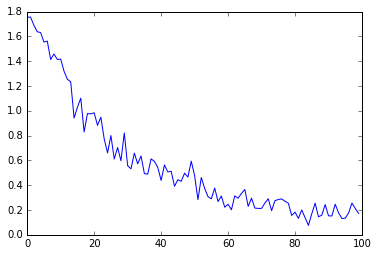

In [11]:
plt.plot(losses)
plt.show()